In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import concurrent.futures

import seaborn as sns
from sklearn.metrics import mean_squared_error
from likelihood import process_agent, process_agent_map

from utils.feature_utils import get_condition_aware_labels
from utils.evaluation_utils import add_corr_scores
from sklearn.metrics import mean_squared_error

from likelihood import sa_neg_log_likelihood_v2, wm3_sa_neg_log_likelihood, sa_mixture_neg_log_likelihood, uniform_prior, beta_prior

In [2]:
BETA_MULTIPLIER = 20
metadata_by_task = {
    "wmh": {
        "bounds": {
            "alpha": (0.2, 0.8),
            "stickiness": (-0.2, 0.2),
            "phi": (0, 0.4),
            "bias": (0, 1),
            "eps": (0, 1),
            "eta6_wm": (0, 1),
        },
        "r0": 1,
        "likelihood_func": sa_mixture_neg_log_likelihood,
        "prior_func": {
            "alpha": uniform_prior(0.2, 0.8),
            "stickiness": uniform_prior(-0.2, 0.2),
            "phi": beta_prior(4.4375, 13.3125, 0, 0.4),
            "bias": uniform_prior(0, 1),
            "eps": beta_prior(0.8, 7.2, 0, 1),
            "eta6_wm": beta_prior(14, 6, 0, 1),
        },
    },    
    "wmbn": {
        "bounds": {
            "stickiness": (-0.2, 0.2),
            "phi": (0, 0.4),
            "bias": (0, 1),
            "eps": (0, 1),
        },
        "likelihood_func": sa_neg_log_likelihood_v2,
        "prior_func": {
            "stickiness": uniform_prior(-0.2, 0.2),
            "phi": beta_prior(4.4375, 13.3125, 0, 0.4),
            "bias": uniform_prior(0, 1),
            "eps": beta_prior(0.8, 7.2, 0, 1),
        },
    },
    "wmb": {
        "bounds": {
            "beta": (0.2, 0.8),
            "stickiness": (-0.2, 0.2),
            "phi": (0, 1),
            "bias": (0, 1),
        },
        "likelihood_func": sa_neg_log_likelihood_v2,
    },    
    "wm": {
        "param_names": ["beta", "stickiness", "phi"],
        "bounds": [(0.2, 0.8), (-0.2, 0.2), (0, 0.4)],
        "multipliers": np.array([BETA_MULTIPLIER, 1, 1]),
        "likelihood_func": wm3_sa_neg_log_likelihood,
        # "hello": ["beta", "stickiness", "phi"],
        "prior_func": [
            uniform_prior(0.2, 0.8),
            uniform_prior(-0.2, 0.2),
            beta_prior(4.4375, 13.3125, 0, 0.4),
        ],
    },
    "shared": {
        "param_names": ["alpha0", "alpha1", "beta"],
        "bounds": [(0.01, 1), (0.01, 1), (0.01, 1)],
        "multipliers": np.array([1, 1, 10]),
    },
}

In [3]:
N_TEST_AGENT = 500
num_blocks = 12
num_trials_per_block = 6 * 13
task = "wmh_6s3a"
suffix = "wmh_no_switch_b25"  #''2ParamRL_no_switch' #'
prefix = f"{N_TEST_AGENT}a_{num_blocks}b_{num_trials_per_block}t_{suffix}"
data = pd.read_csv(
    f"data/{task}/{N_TEST_AGENT}a_{num_blocks}b_{num_trials_per_block}t_{suffix}.csv"
)

metadata = metadata_by_task["wmh"]

# Run Optimizer

In [6]:
from scipy.optimize import minimize
from concurrent.futures import ProcessPoolExecutor
import time

# Main execution
start_time = time.time()

# Get unique agent IDs (limit to 200 if needed)
limit = 500
method = "MAP"

agent_ids = data.agentid.unique()
agent_ids = agent_ids[:limit]
process_func = process_agent_map if method == "MAP" else process_agent
est_params = []
max_workers = 7
# Run the optimization in parallel
with ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks
    future_to_aid = {
        executor.submit(
            process_func,
            aid,
            data,
            metadata,
            metadata["bounds"],
        ): aid
        for aid in agent_ids
    }

    # Process results as they complete
    results = {}
    for future in concurrent.futures.as_completed(future_to_aid):
        aid = future_to_aid[future]
        try:
            agent_id, params = future.result()
            if params is not None:
                results[agent_id] = params
        except Exception as e:
            print(f"Agent {aid} generated an exception: {str(e)}")

# Convert results to the same format as before
est_params = [results[aid] for aid in sorted(results.keys()) if aid in results]

print(f"Total agents processed: {len(est_params)}")
est_params = np.array(est_params)

# Build the dataframe
recovered_param = {}

param_names = sorted(list(metadata["bounds"].keys()))
for idx, pn in enumerate(param_names):
    if metadata["bounds"][pn][0] != metadata["bounds"][pn][1]:
        recovered_param[pn] = est_params[:, idx]

recovered_param = pd.DataFrame(recovered_param)

# Print timing information
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

Starting MAP optimization for agent 0...
Starting MAP optimization for agent 1...
Starting MAP optimization for agent 2...
Starting MAP optimization for agent 3...
Starting MAP optimization for agent 4...
Starting MAP optimization for agent 5...
Starting MAP optimization for agent 6...
Completed MAP optimization for agent 2
Starting MAP optimization for agent 7...
Completed MAP optimization for agent 5
Completed MAP optimization for agent 4
Starting MAP optimization for agent 8...
Starting MAP optimization for agent 9...
Completed MAP optimization for agent 3
Completed MAP optimization for agent 1
Starting MAP optimization for agent 10...
Starting MAP optimization for agent 11...
Completed MAP optimization for agent 0
Starting MAP optimization for agent 12...
Completed MAP optimization for agent 7
Starting MAP optimization for agent 13...
Completed MAP optimization for agent 9
Starting MAP optimization for agent 14...
Completed MAP optimization for agent 6
Starting MAP optimization for

# Eval

Text(0.5, 1.01, 'MAP')

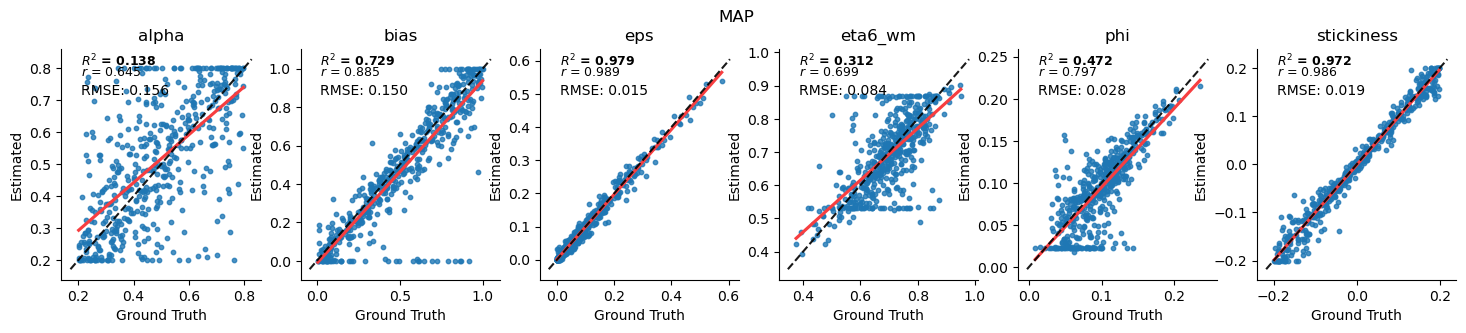

In [7]:
# @title model parameters

recovered_param = recovered_param.rename(columns={"nalpha": "neg_alpha"})
data['bias'] = data['wm_bias']
param_names = list(recovered_param.keys())

if task != "shared":
    shared, conditioned = param_names, []
else:
    shared, conditioned = ["beta"], ["alpha"]

n_cols = len(param_names)
true_name_labels = get_condition_aware_labels(
    data[data.agentid < limit], shared, conditioned
)

#true_name_labels['beta'] = true_name_labels['beta'] / BETA_MULTIPLIER

fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(3 * n_cols, 3))
for idx, pn in enumerate(sorted(param_names)):
    y_true = true_name_labels[pn].ravel()
    y_pred = recovered_param[pn]

    result = pd.DataFrame({pn: y_true, "mle": y_pred})
    ax = sns.regplot(
        data=result,
        ci=None,
        x=pn,
        y="mle",
        line_kws=dict(color="#f73e40"),
        scatter_kws=dict(s=10),
        ax=axes.flat[idx],
    )
    ax.plot(
        [ax.get_xlim()[0], ax.get_xlim()[1]],
        [ax.get_xlim()[0], ax.get_xlim()[1]],
        color="black",
        alpha=0.9,
        linestyle="dashed",
    )
    sns.despine()

    ax = add_corr_scores(ax, y_true, y_pred)

    mse = mean_squared_error(
        y_true, y_pred, squared=False
    )
    ax.text(0.1, 0.8, f"RMSE: {mse:.3f}", transform=ax.transAxes, fontsize=10)
    ax.set_xlabel("Ground Truth")
    ax.set_ylabel("Estimated")
    ax.set_title(pn, fontsize=12)

fig.suptitle(method, y=1.01)

In [16]:
prefix = f"{N_TEST_AGENT}a_{num_blocks}b_{num_trials_per_block}t_{suffix}"
recovered_param.to_csv(f"results/{method}_{task}_{prefix}.csv")

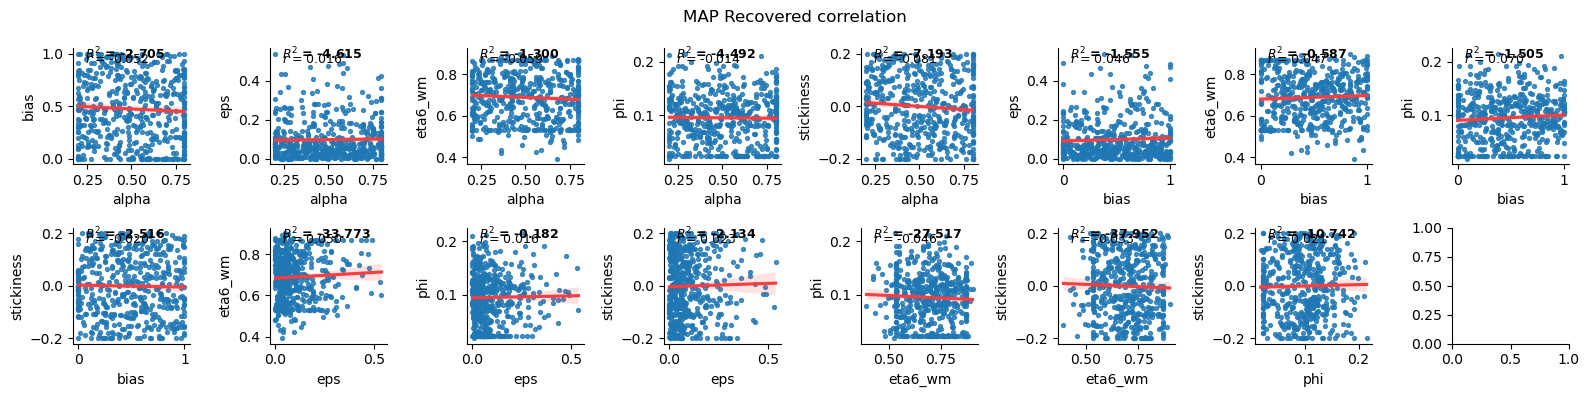

In [15]:
import math

n_col = len(param_names) * (len(param_names) - 1) // 2
n_row = 2
n_col = math.ceil(n_col/n_row)
fig, axes = plt.subplots(n_row, n_col, figsize=(2 * n_col, 2 * n_row))
#multipliers = {p: metadata["multipliers"][i] for i, p in enumerate(param_names)}
ai = 0
flatted_axes = axes.flatten()
for i, pn1 in enumerate(param_names):
    for j, pn2 in enumerate(param_names[i + 1 :]):
        y_true, y_pred = recovered_param[pn1], recovered_param[pn2]
        ax = flatted_axes[ai]
        sns.regplot(
            x=y_true,
            y=y_pred,
            ax=ax,
            line_kws=dict(color="#f73e40"),
            scatter_kws=dict(s=8),
        )
        ax = add_corr_scores(ax, y_true, y_pred)
        ax.set_xlabel(pn1)
        ax.set_ylabel(pn2)
        ai += 1

sns.despine()
fig.suptitle(f"{method} Recovered correlation")
fig.tight_layout()